## **주식 예측에 도전해 보자!**

### **STEP 1 : 시계열 데이터 준비 (Samsung)**
* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
* 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# DataFrame으로 변환
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [3]:
# Time Series 생성
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

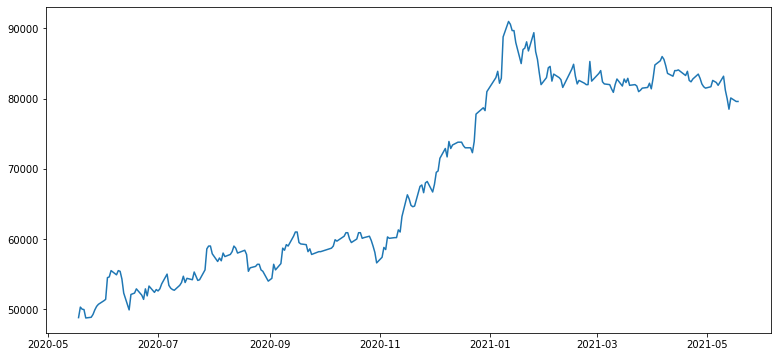

In [4]:
# 데이터 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

### **STEP 2 : 각종 전처리 수행**
* 결측치 처리
* 로그 변환

In [5]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력한다.

Series([], Name: Close, dtype: float64)

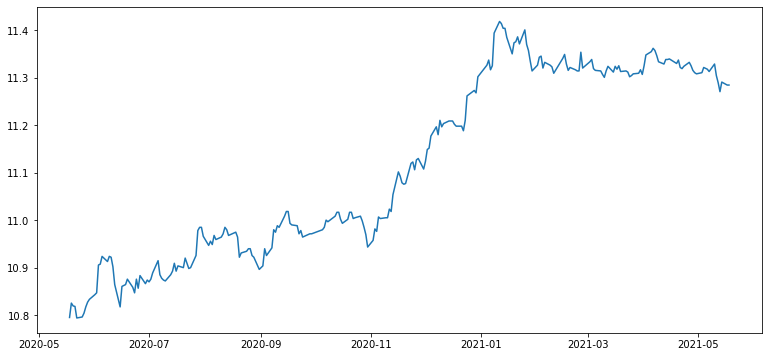

In [6]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

### **STEP 3 : 시계열 안정성 분석**
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

In [7]:
# 구간 통계치(Rolling Statistics) 정의
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

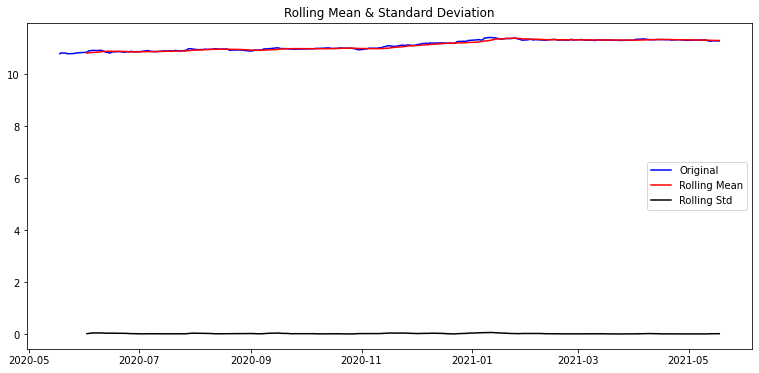

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [9]:
# Augmented Dickey-Fuller Test 정의
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출한다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력한다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


**p-value가 0.05 이상으로 해당 시계열이 안정적인 시계열이라고 할 수 없다.**

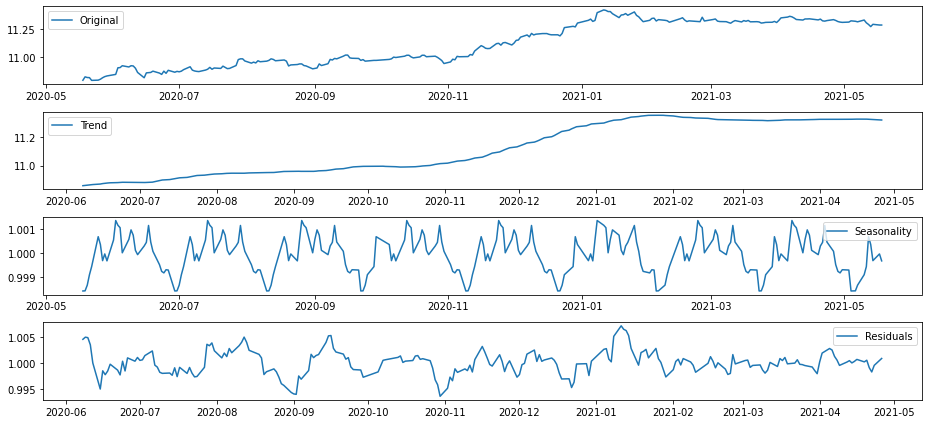

In [11]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [12]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


**압도적으로 낮은 p-value를 보여주고 있으므로 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있다.**

### **STEP 4 : 학습, 테스트 데이터셋 생성**
* 학습, 테스트 데이터셋 분리

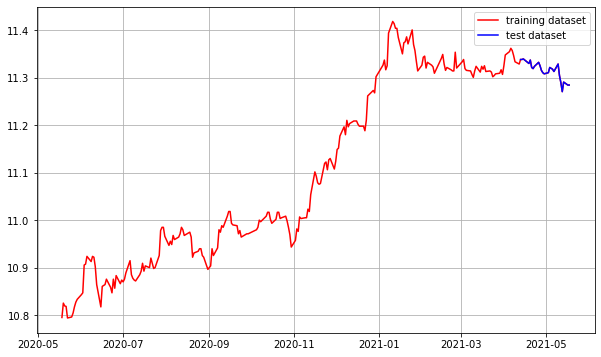

In [13]:
# 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### **STEP 5 : 적정 ARIMA 모수 찾기**
* ACF, PACF 그려보기 -> p, q 구하기
* 차분 안정성 확인 -> d 구하기

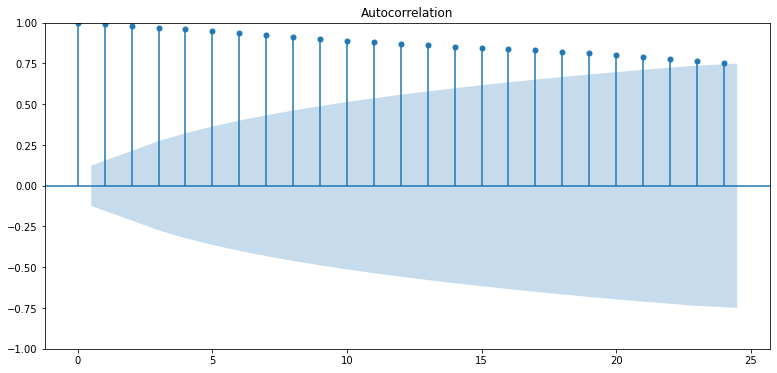

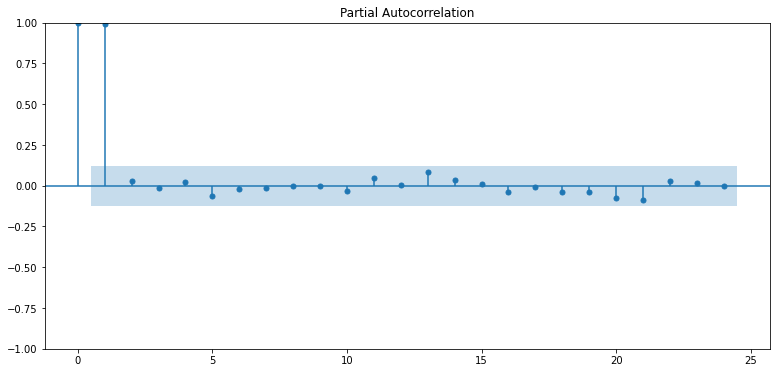

In [14]:
# ACF, PACF 그려보기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log) # ACF: Autocorrelation 그래프 그리기
plot_pacf(ts_log, method='ywm') # PACF: Partial Autocorrelation 그래프 그리기
plt.show()

ACF는 천천히 감소하고 PACF는 lag 1 이후에 급격하게 하락하는 것을 볼 수 있다.
<br>**일단 p = 1로 두고 q는 값을 바꿔가면서 결과를 확인해보도록 하자!**

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


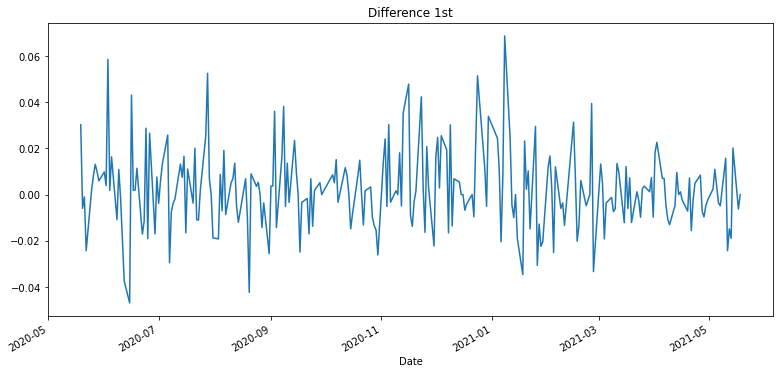

In [15]:
# 차분 안정성 확인
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차분 만으로도 충분히 안정화된 그래프를 확인할 수 있어 2차분은 진행하지 않기로 했다.
<br>**일단 d = 1로 시도해보고 p, q와 마찬가지로 값을 바꿔가며 모델의 예측 능력을 확인해보기로 하겠다.**

### **STEP 6 : ARIMA 모델 훈련과 테스트**
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

#### **ARIMA(1,1,1)**

In [16]:
import warnings
warnings.filterwarnings('ignore') # 경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train Model
model = ARIMA(train_data, order=(1,1,1))
fitted_m = model.fit()
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 583.489
Date:                Fri, 14 Apr 2023   AIC                          -1160.979
Time:                        05:27:06   BIC                          -1150.744
Sample:                             0   HQIC                         -1156.847
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0126      2.094      0.006      0.995      -4.092       4.117
ma.L1          0.0237      2.102      0.011      0.991      -4.096       4.143
sigma2         0.0003   2.47e-05     12.936      0.0

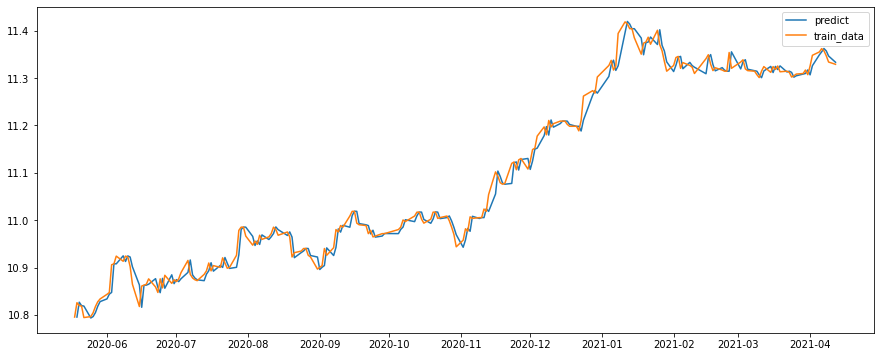

In [17]:
# 훈련 결과 시각화
fitted_m_predict = fitted_m.predict()
fitted_m_predict = fitted_m_predict.drop(fitted_m_predict.index[0])
plt.figure(figsize=(15, 6))
plt.plot(fitted_m_predict, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

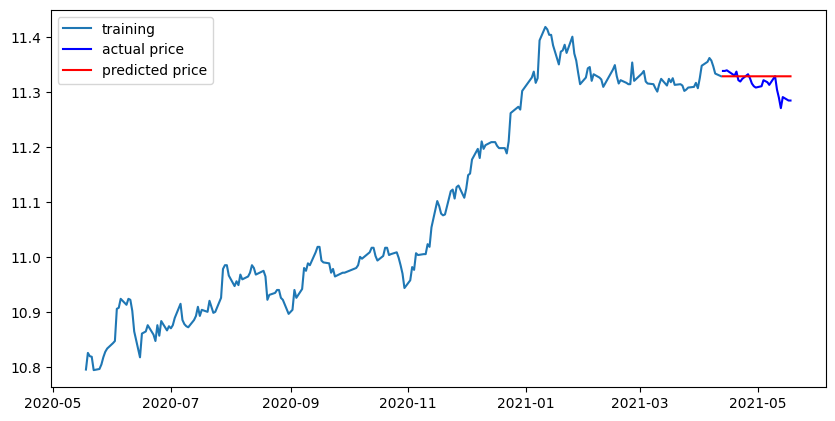

In [18]:
# Forecast: 결과가 fc에 담긴다.
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) # 예측결과

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape * 100))

MSE:  3480580.457711579
MAE:  1403.0537770723201
RMSE:  1865.631383127862
MAPE: 1.74%


#### **(추가) 모델 성능 측정 함수 정의**

In [20]:
def arima_result(p,d,q):
    
    # 1. ARIMA 모델 빌드와 훈련
    model = ARIMA(train_data, order=(p,d,q))
    fitted_m = model.fit()
    print(fitted_m.summary())
    
    # 2. ARIMA 모델 훈련 결과 시각화
    fitted_m_predict = fitted_m.predict()
    fitted_m_predict = fitted_m_predict.drop(fitted_m_predict.index[0])
    plt.figure(figsize=(15, 6))
    plt.plot(fitted_m_predict, label='predict')
    plt.plot(train_data, label='train_data')
    plt.legend()
    
    # 3. 모델 테스트 및 플로팅
    # Forecast
    fc = fitted_m.forecast(len(test_data), alpha=0.05) 
    fc = np.array(fc)

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)

    # Plot
    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()
    
    # 4. 최종 예측 모델 정확도 측정(MAPE)
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape * 100))

#### **ARIMA(1,1,2)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 583.491
Date:                Fri, 14 Apr 2023   AIC                          -1158.981
Time:                        05:27:07   BIC                          -1145.334
Sample:                             0   HQIC                         -1153.473
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2891     45.612     -0.006      0.995     -89.687      89.109
ma.L1          0.3205     45.621      0.007      0.994     -89.096      89.737
ma.L2          0.0105      1.421      0.007      0.9

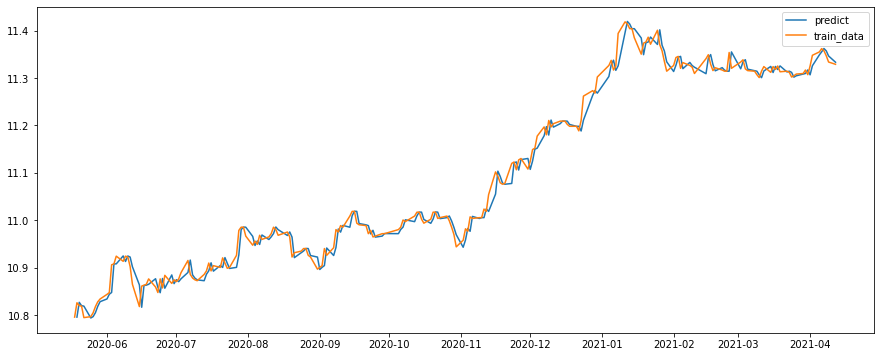

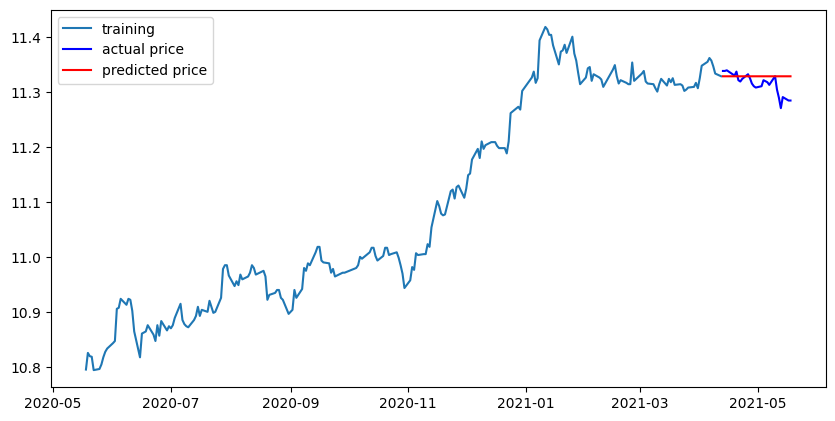

MSE:  3482473.446381117
MAE:  1403.3802095638152
RMSE:  1866.1386460767371
MAPE: 1.74%


In [21]:
arima_result(1,1,2)

#### **ARIMA(1,1,3)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 583.497
Date:                Fri, 14 Apr 2023   AIC                          -1156.995
Time:                        05:27:08   BIC                          -1139.937
Sample:                             0   HQIC                         -1150.109
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7582     18.392     -0.041      0.967     -36.806      35.290
ma.L1          0.7917     18.394      0.043      0.966     -35.259      36.842
ma.L2          0.0175      0.618      0.028      0.9

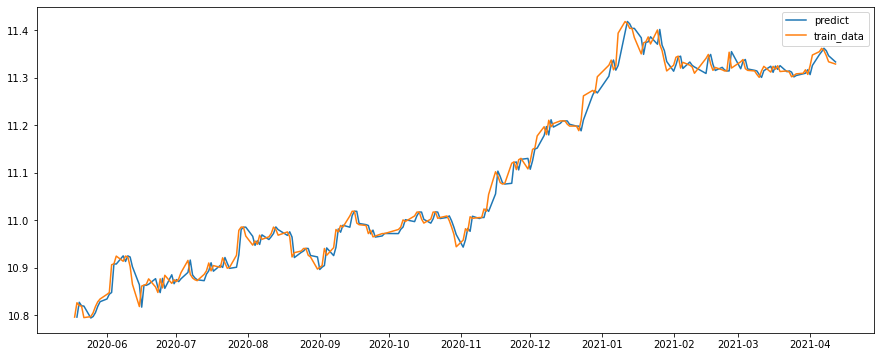

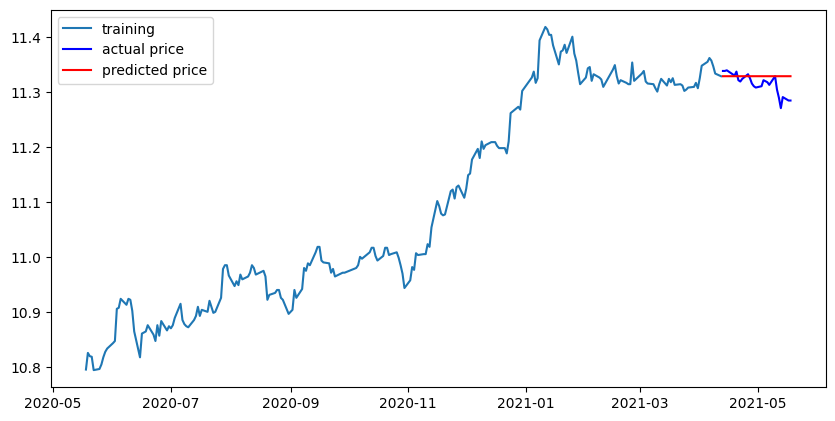

MSE:  3509927.2537589143
MAE:  1408.1599144333468
RMSE:  1873.479984883456
MAPE: 1.74%


In [22]:
arima_result(1,1,3)

p와 d는 1로 두고 q를 바꿔본 결과, MAPE에는 아무런 차이가 없다는 것을 확인할 수 있다.

#### **ARIMA(1,0,1)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 583.370
Date:                Fri, 14 Apr 2023   AIC                          -1158.741
Time:                        05:27:09   BIC                          -1145.076
Sample:                             0   HQIC                         -1153.226
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.127     87.360      0.000      10.841      11.338
ar.L1          0.9942      0.006    157.934      0.000       0.982       1.007
ma.L1          0.0392      0.063      0.623      0.5

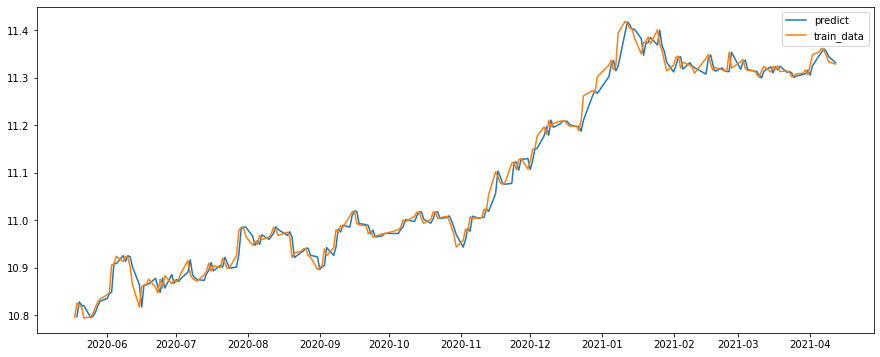

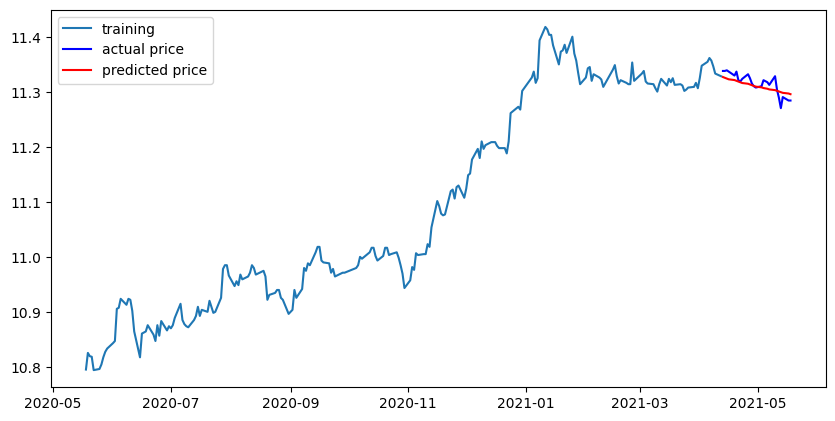

MSE:  1057119.8161340475
MAE:  850.8270312480739
RMSE:  1028.1633217218202
MAPE: 1.04%


In [23]:
arima_result(1,0,1)

#### **ARIMA(1,0,2)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 583.245
Date:                Fri, 14 Apr 2023   AIC                          -1156.491
Time:                        05:27:11   BIC                          -1139.410
Sample:                             0   HQIC                         -1149.597
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0713      0.109    101.360      0.000      10.857      11.285
ar.L1          0.9933      0.006    157.081      0.000       0.981       1.006
ma.L1          0.0460      0.063      0.729      0.4

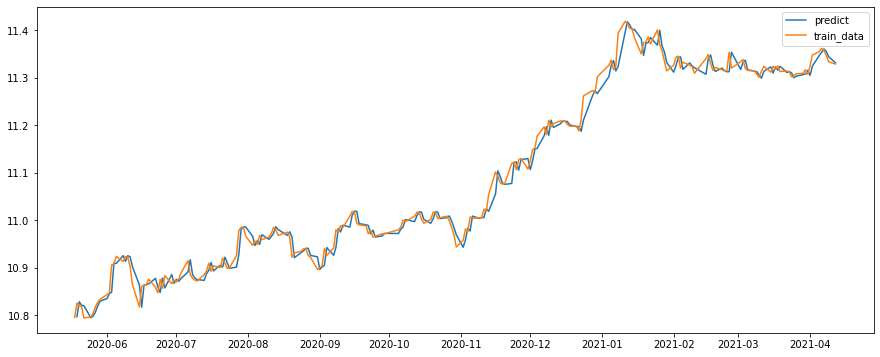

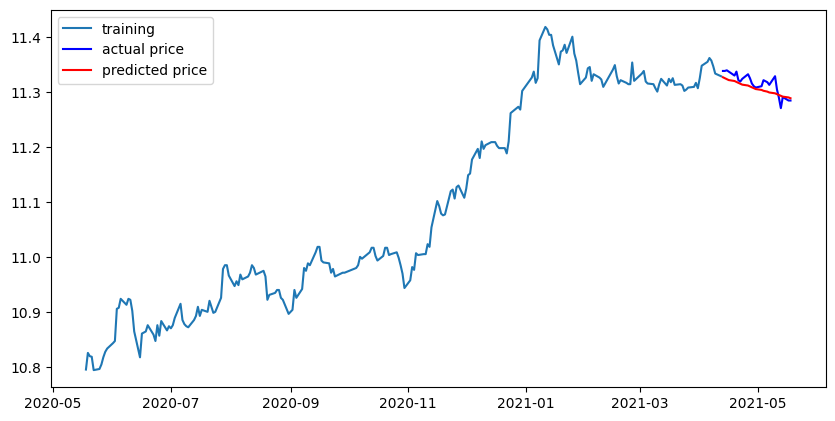

MSE:  1248344.6362079717
MAE:  943.2987087532284
RMSE:  1117.2934423006213
MAPE: 1.14%


In [24]:
arima_result(1,0,2)

#### **ARIMA(1,0,3)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 583.655
Date:                Fri, 14 Apr 2023   AIC                          -1155.309
Time:                        05:27:12   BIC                          -1134.813
Sample:                             0   HQIC                         -1147.037
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0140      0.187     59.024      0.000      10.648      11.380
ar.L1          0.9965      0.006    161.332      0.000       0.984       1.009
ma.L1          0.0431      0.063      0.686      0.4

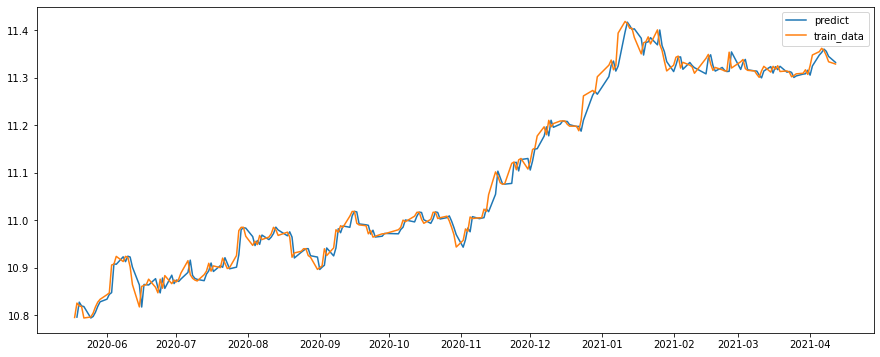

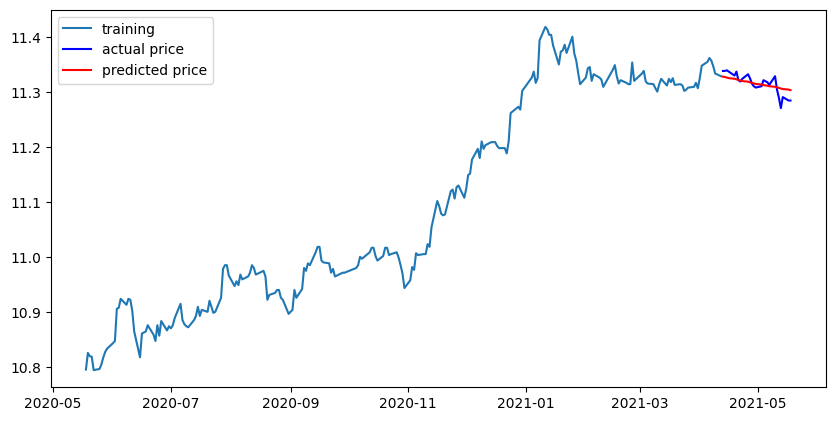

MSE:  1109812.5881743582
MAE:  843.7237818092055
RMSE:  1053.4764298143355
MAPE: 1.03%


In [25]:
arima_result(1,0,3)

d = 0으로 지정해주었더니 MAPE 점수가 떨어진 것을 확인할 수 있다.

#### **ARIMA(2,0,1)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Fri, 14 Apr 2023   AIC                          -1156.722
Time:                        05:27:13   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

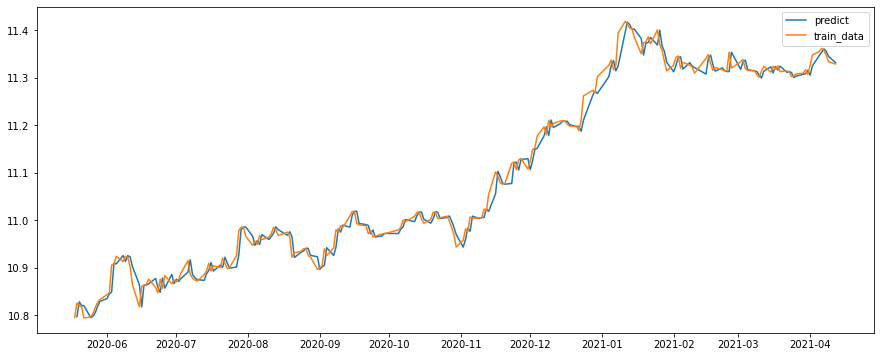

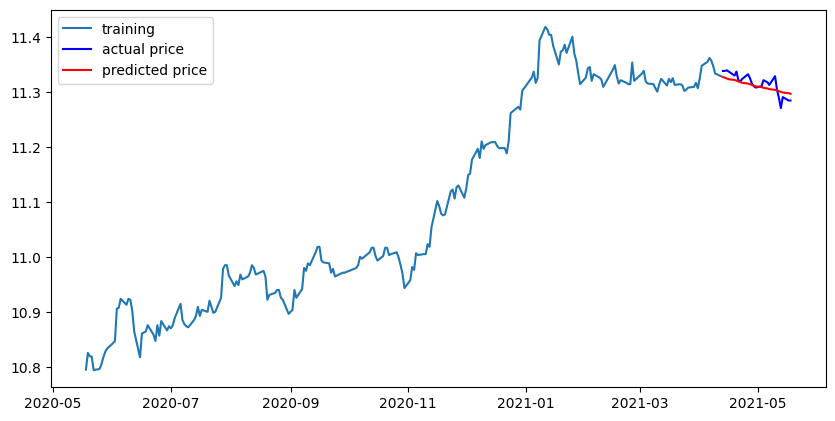

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


In [26]:
arima_result(2,0,1)

#### **ARIMA(2,0,2)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 583.607
Date:                Fri, 14 Apr 2023   AIC                          -1155.215
Time:                        05:27:15   BIC                          -1134.718
Sample:                             0   HQIC                         -1146.942
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0688      0.196     56.407      0.000      10.684      11.453
ar.L1          0.2660     32.234      0.008      0.993     -62.911      63.443
ar.L2          0.7287     32.134      0.023      0.9

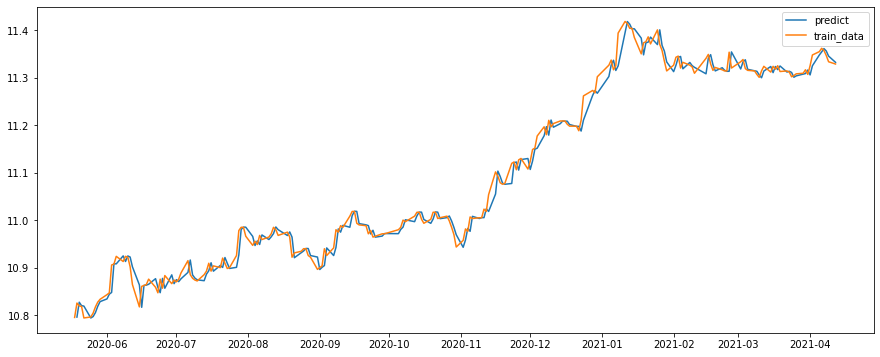

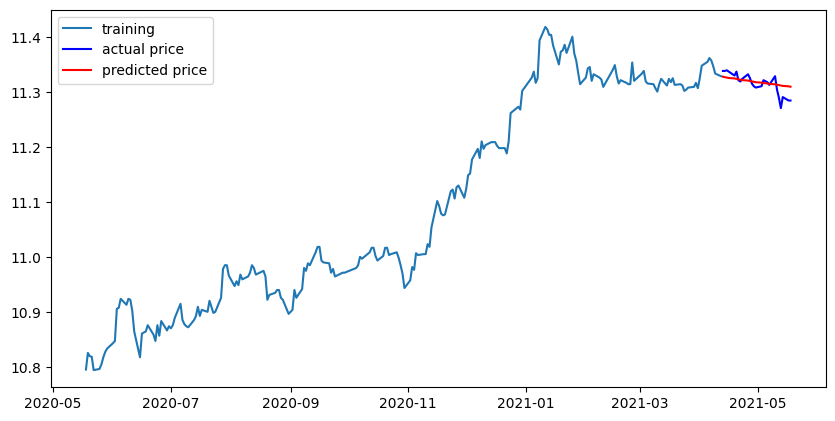

MSE:  1427822.3540262028
MAE:  933.7248352184944
RMSE:  1194.9152078813804
MAPE: 1.15%


In [27]:
arima_result(2,0,2)

#### **ARIMA(2,0,3)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 583.605
Date:                Fri, 14 Apr 2023   AIC                          -1153.209
Time:                        05:27:16   BIC                          -1129.297
Sample:                             0   HQIC                         -1143.558
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0533      0.217     50.985      0.000      10.628      11.478
ar.L1          0.2141      2.612      0.082      0.935      -4.905       5.333
ar.L2          0.7810      2.606      0.300      0.7

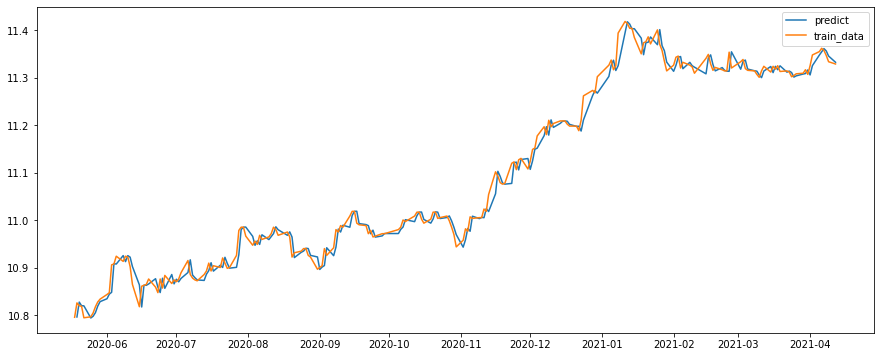

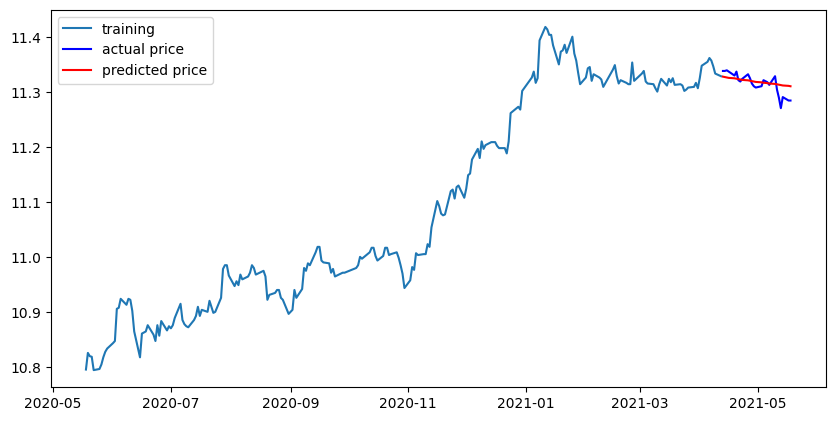

MSE:  1480082.07383483
MAE:  945.9747055446176
RMSE:  1216.5862377303263
MAPE: 1.16%


In [28]:
arima_result(2,0,3)

|p|d|q|MAPE(%)|
|------|---|---|---|
|1|1|1|1.74|
|1|1|2|1.74|
|1|1|3|1.74|
|1|0|1|1.04|
|1|0|2|1.14|
|1|0|3|1.03|
|2|0|1|1.03|
|2|0|2|1.15|
|2|0|3|1.16|

**ARIMA(1,0,3)과 ARIMA(2,0,1) 모델이 MAPE 1.03%로 가장 성능이 좋은 것을 확인할 수 있다.**

### **STEP 7 : 다른 주식 종목 예측해 보기**
* 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

### **APPLE 🍎**
#### **1. 시계열 데이터 준비** 

In [29]:
# 데이터 불러와서 데이터프레임으로 변환
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-12,168.020004,169.869995,166.639999,167.660004,166.650482,79265200
2022-04-13,167.389999,171.039993,166.770004,170.399994,169.373962,70618900
2022-04-14,170.619995,171.270004,165.039993,165.289993,164.294754,75329400
2022-04-18,163.919998,166.600006,163.570007,165.070007,164.076080,69023900
2022-04-19,165.020004,167.820007,163.910004,167.399994,166.392044,67723800


In [30]:
# Time Series 생성
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2022-04-12    167.660004
2022-04-13    170.399994
2022-04-14    165.289993
2022-04-18    165.070007
2022-04-19    167.399994
Name: Close, dtype: float64

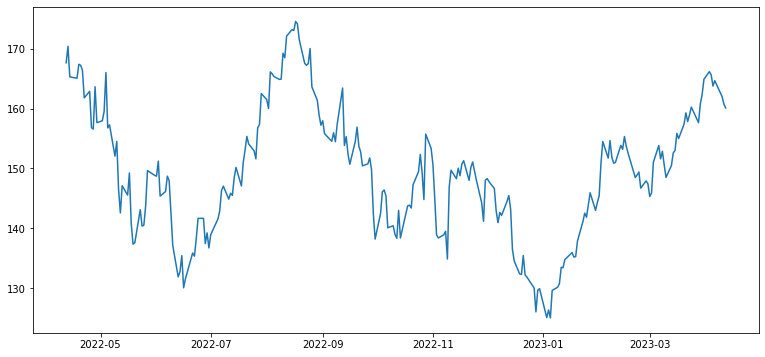

In [31]:
# 데이터 시각화
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

#### **2. 각종 전처리 수행**

In [32]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

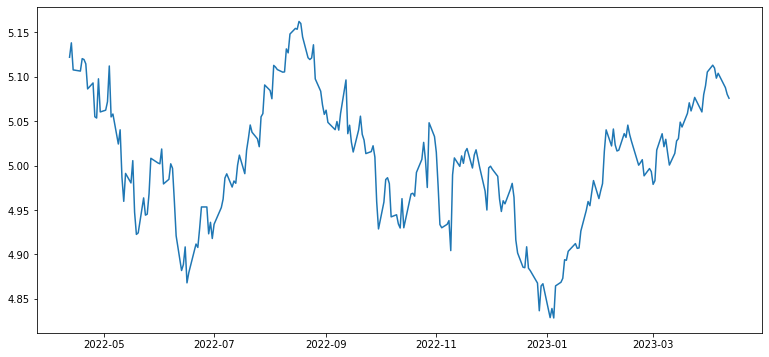

In [33]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

#### **3. 시계열 안정성 분석**

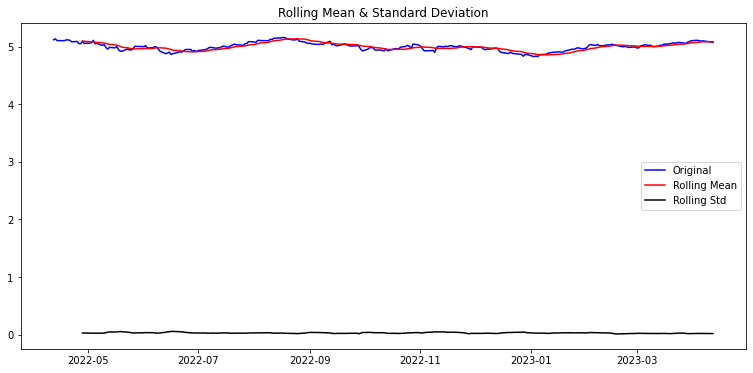

Results of Dickey-Fuller Test:
Test Statistic                  -2.588455
p-value                          0.095407
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


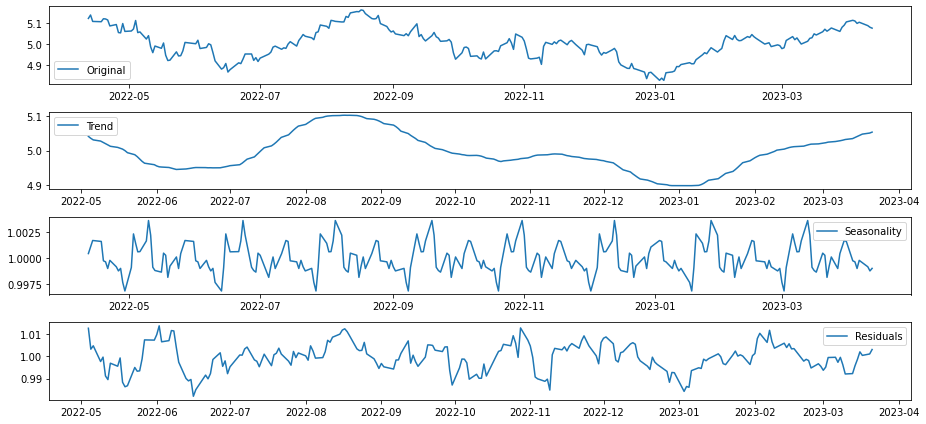

In [34]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [35]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.036794
p-value                          0.000019
#Lags Used                       5.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


p-value가 0.05보다 작으므로 residual이 autocorrelation을 가지고 있다고 해석할 수 있다.
<br>**따라서 residual의 안정성이 괜찮다고 판단할 수 있다.**

#### **4. 학습, 테스트 데이터셋 생성**

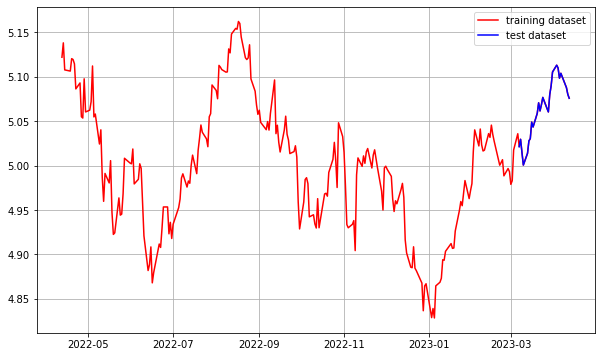

In [36]:
# 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### **5. 적정 ARIMA 모수 찾기**

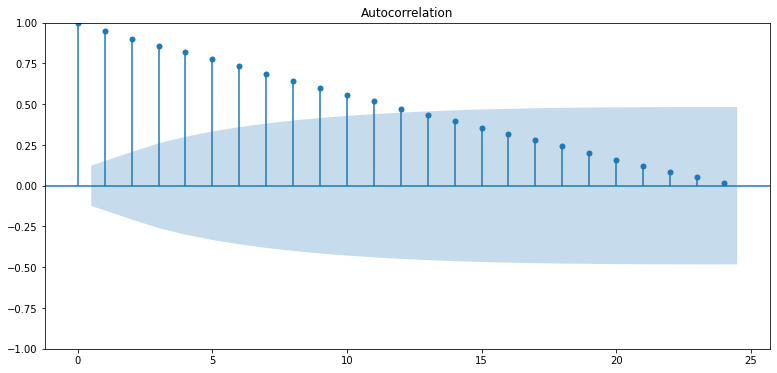

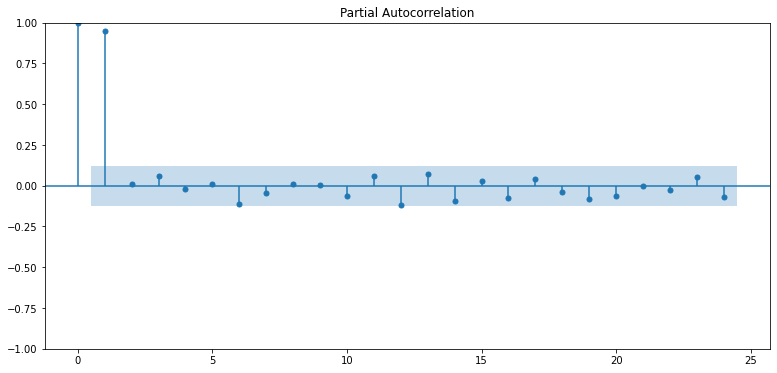

In [37]:
# ACF, PACF 그려보기
plot_acf(ts_log)  
plot_pacf(ts_log, method='ywm')
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.676274e+01
p-value                        1.306116e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


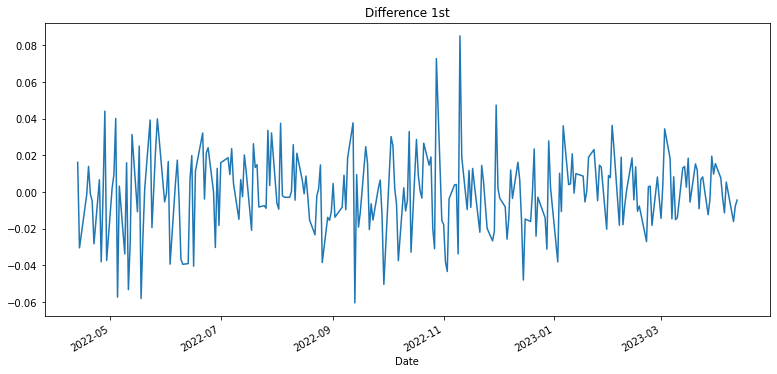

In [38]:
# 1차 차분
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.646619e+00
p-value                        1.835427e-11
#Lags Used                     1.100000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


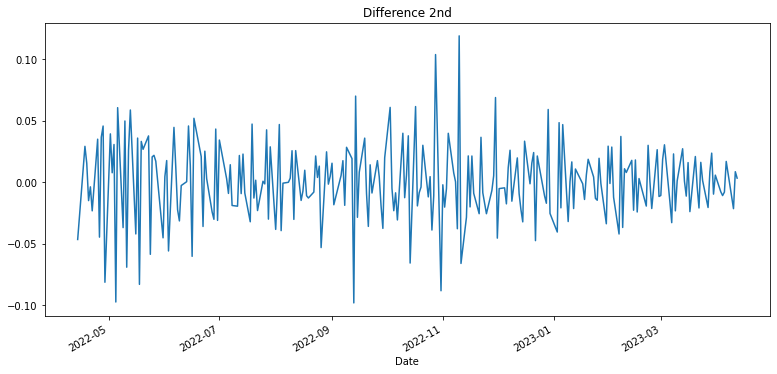

In [39]:
# 2차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

**ARIMA(1,2,q)로 시작해서 값을 하나씩 변경해보며 적당한 모수를 찾아보도록 하자!**

#### **6. ARIMA 모델 훈련과 테스트**

#### **ARIMA(1,2,1)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 526.015
Date:                Fri, 14 Apr 2023   AIC                          -1046.030
Time:                        05:27:20   BIC                          -1035.808
Sample:                             0   HQIC                         -1041.904
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0606      0.068     -0.890      0.373      -0.194       0.073
ma.L1         -0.9964      0.082    -12.079      0.000      -1.158      -0.835
sigma2         0.0005   5.79e-05      8.872      0.0

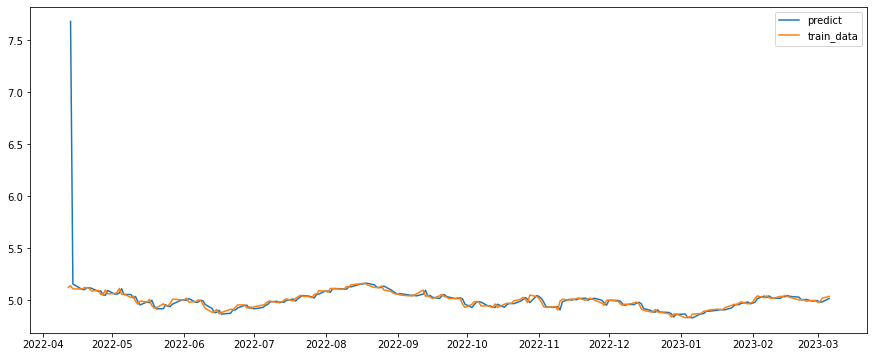

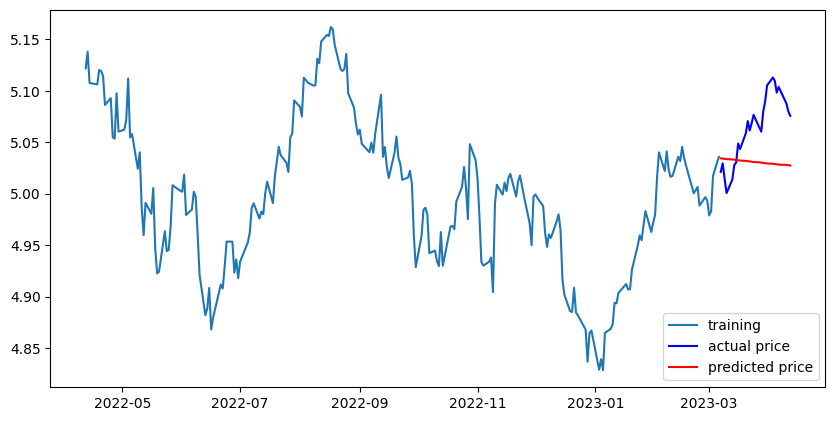

MSE:  53.366888237853054
MAE:  6.18252708809974
RMSE:  7.30526441943432
MAPE: 3.84%


In [40]:
arima_result(1,2,1)

위의 그래프에서 predicted price와 actual price가 선이 어긋나버린 것을 확인할 수 있다.
<br>**하이퍼파라미터를 변경해서 선을 최대한 맞춰보기로 했다.**

#### **ARIMA(1,2,2)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 2)   Log Likelihood                 529.061
Date:                Fri, 14 Apr 2023   AIC                          -1050.121
Time:                        05:27:22   BIC                          -1036.492
Sample:                             0   HQIC                         -1044.619
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9117      0.039    -23.381      0.000      -0.988      -0.835
ma.L1         -0.0102      5.381     -0.002      0.998     -10.556      10.536
ma.L2         -0.9897      5.325     -0.186      0.8

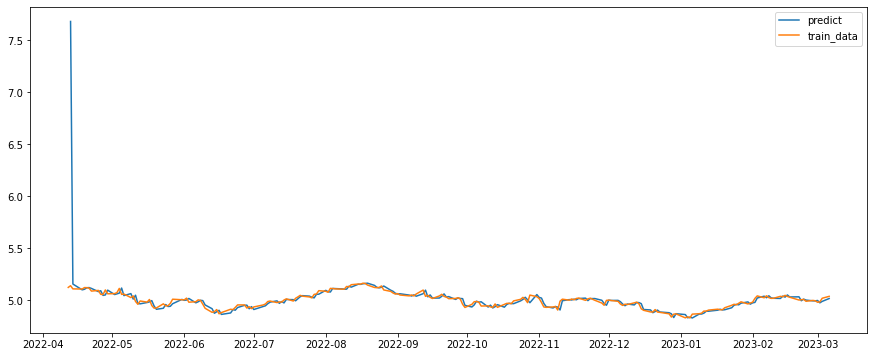

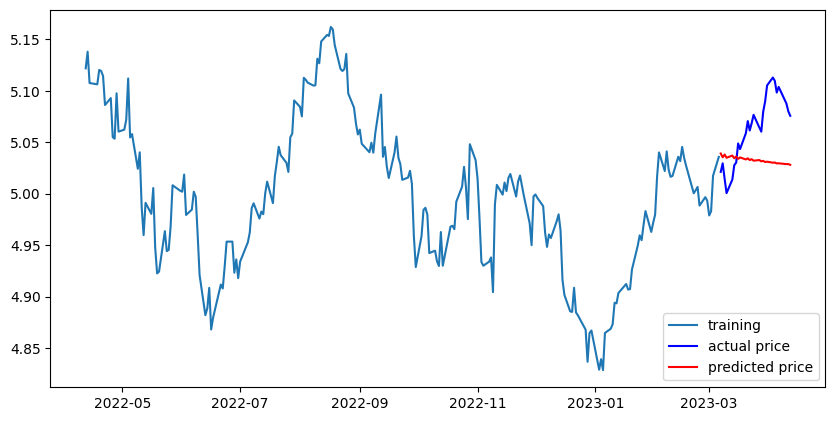

MSE:  51.5833267891702
MAE:  6.129258179646261
RMSE:  7.182153353220063
MAPE: 3.82%


In [41]:
arima_result(1,2,2)

#### **ARIMA(1,2,3)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 3)   Log Likelihood                 530.495
Date:                Fri, 14 Apr 2023   AIC                          -1050.991
Time:                        05:27:23   BIC                          -1033.955
Sample:                             0   HQIC                         -1044.114
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8811      0.044    -19.815      0.000      -0.968      -0.794
ma.L1         -0.1447      0.341     -0.425      0.671      -0.813       0.523
ma.L2         -0.9821      0.297     -3.303      0.0

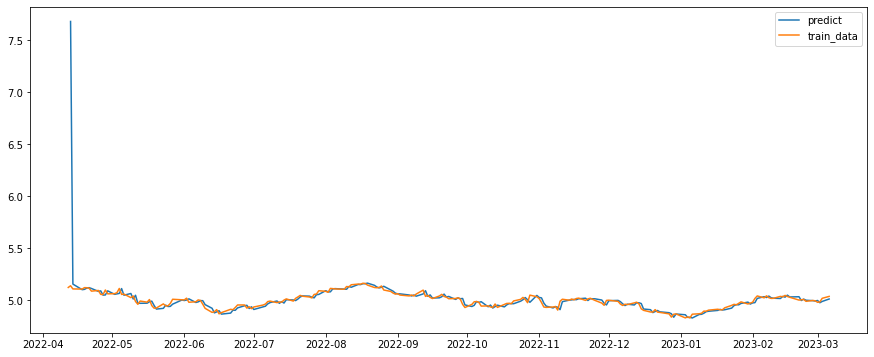

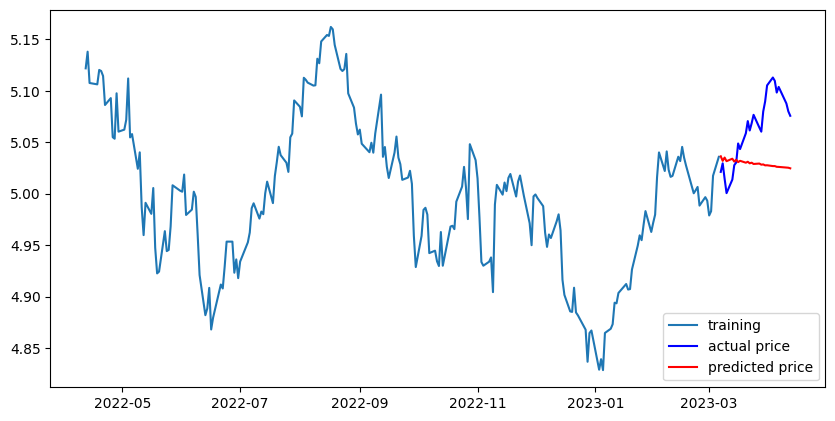

MSE:  56.77015245226175
MAE:  6.372391190628115
RMSE:  7.534597033170503
MAPE: 3.96%


In [42]:
arima_result(1,2,3)

q 값을 변경해주었더니 MAPE 값이 오히려 더 높아졌다.
<br>p = 2로 바꿔보자!

#### **ARIMA(2,2,3)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 2, 3)   Log Likelihood                 526.118
Date:                Fri, 14 Apr 2023   AIC                          -1040.235
Time:                        05:27:25   BIC                          -1019.792
Sample:                             0   HQIC                         -1031.983
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2020      0.553     -2.173      0.030      -2.286      -0.118
ar.L2         -0.6052      0.541     -1.118      0.263      -1.666       0.455
ma.L1          0.1715      0.572      0.300      0.7

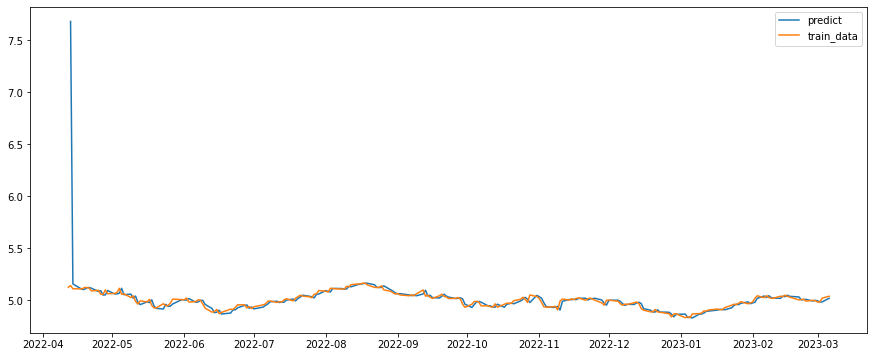

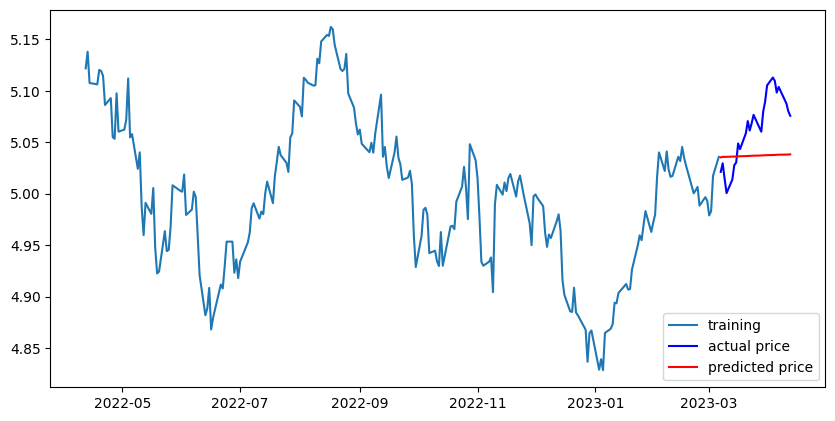

MSE:  40.94502595284269
MAE:  5.455111645502336
RMSE:  6.3988300456288645
MAPE: 3.40%


In [43]:
arima_result(2,2,3)

predicted price의 빨간 선이 이전보다 올라온 것을 확인할 수 있다.
<br>그렇다면 이번에는 d 값을 변경해보면 어떨까?

#### **ARIMA(2,3,3)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 3, 3)   Log Likelihood                 520.778
Date:                Fri, 14 Apr 2023   AIC                          -1029.555
Time:                        05:27:26   BIC                          -1009.139
Sample:                             0   HQIC                         -1021.312
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0172      0.073    -13.948      0.000      -1.160      -0.874
ar.L2         -0.1040      0.070     -1.481      0.139      -0.242       0.034
ma.L1         -0.9867      1.970     -0.501      0.6

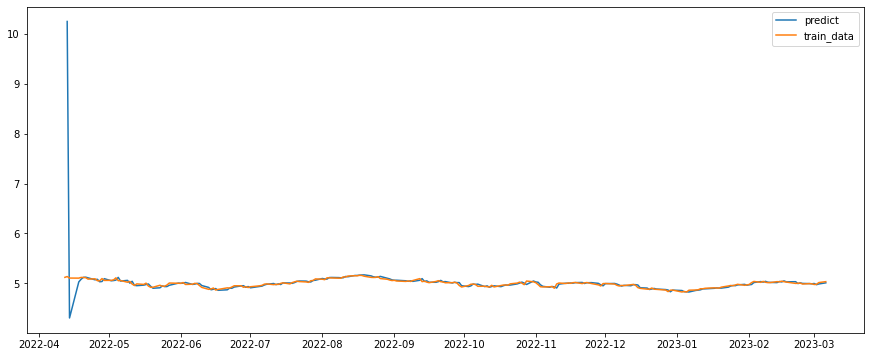

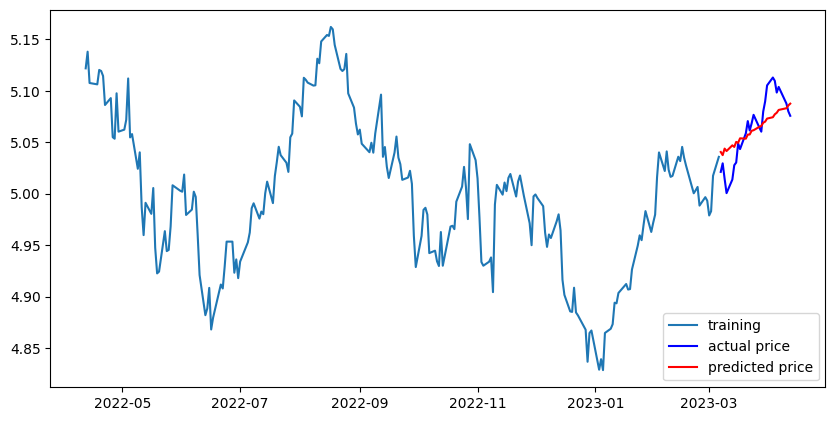

MSE:  10.166422098767468
MAE:  2.603723471997007
RMSE:  3.188482726747546
MAPE: 1.65%


In [44]:
arima_result(2,3,3)

이제 제법 그럴싸한 그래프가 생성이 된 것 같다 😀

#### **ARIMA(1,3,3)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 3, 3)   Log Likelihood                 519.507
Date:                Fri, 14 Apr 2023   AIC                          -1029.014
Time:                        05:27:28   BIC                          -1012.001
Sample:                             0   HQIC                         -1022.145
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9204      0.037    -24.601      0.000      -0.994      -0.847
ma.L1         -0.9787      0.530     -1.847      0.065      -2.018       0.060
ma.L2         -0.9992      1.017     -0.982      0.3

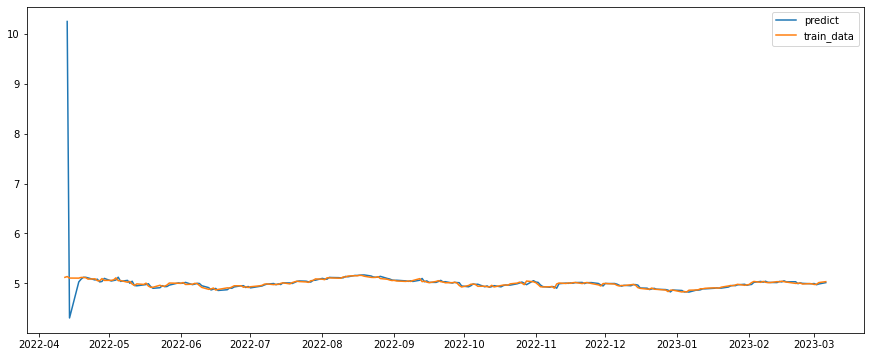

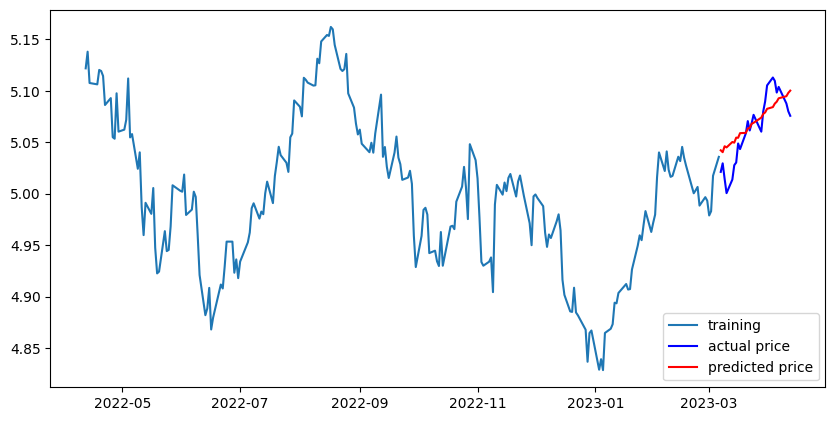

MSE:  9.159012507235818
MAE:  2.474708102610008
RMSE:  3.0263860472906985
MAPE: 1.58%


In [45]:
arima_result(1,3,3)

|p|d|q|MAPE(%)|
|------|---|---|---|
|1|2|1|3.84|
|1|2|2|3.82|
|1|2|3|3.96|
|2|2|3|3.40|
|2|3|3|1.65|
|1|3|3|1.58|

**ARIMA(1,3,3) 모델이 MAPE 1.58%로 가장 좋은 성능을 보여준다.**

### **AMAZON**
#### **1. 시계열 데이터 준비** 

In [46]:
# 데이터 불러와서 데이터프레임으로 변환
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AMZN.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-13,150.018494,156.024994,149.600006,155.541000,155.541000,53390000
2022-04-14,155.389999,155.897003,151.472000,151.706497,151.706497,51598000
2022-04-18,151.523499,154.039505,150.250504,152.785004,152.785004,46514000
2022-04-19,152.029495,158.649002,151.550507,158.115494,158.115494,54926000
2022-04-20,157.602493,157.602493,153.603500,153.998001,153.998001,59630000


In [47]:
# Time Series 생성
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2022-04-13    155.541000
2022-04-14    151.706497
2022-04-18    152.785004
2022-04-19    158.115494
2022-04-20    153.998001
Name: Close, dtype: float64

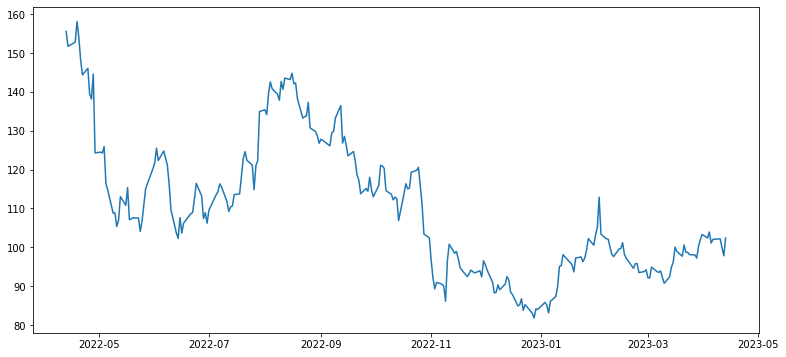

In [48]:
# 데이터 시각화
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

#### **2. 각종 전처리 수행**

In [49]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

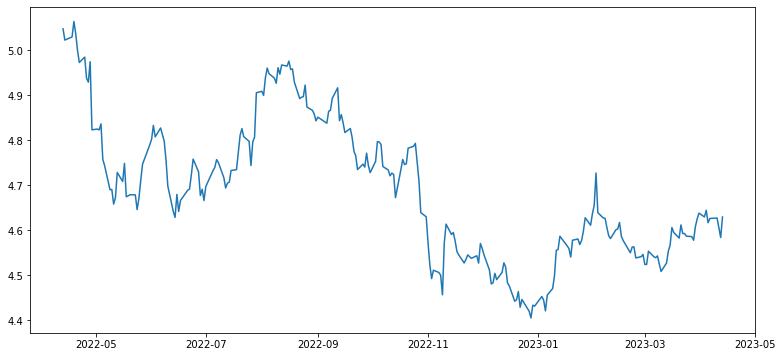

In [50]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

#### **3. 시계열 안정성 분석**

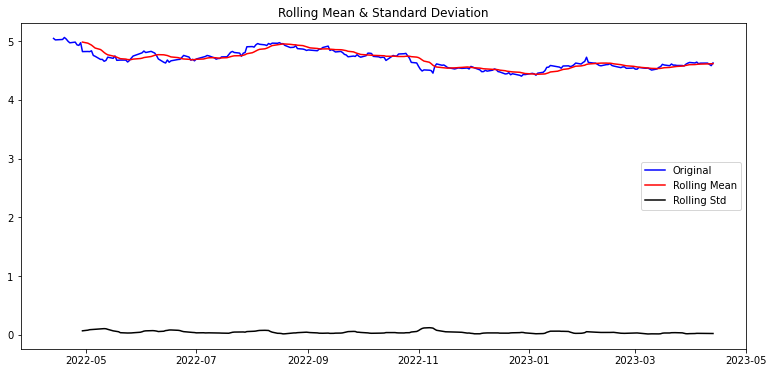

Results of Dickey-Fuller Test:
Test Statistic                  -2.454350
p-value                          0.126980
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


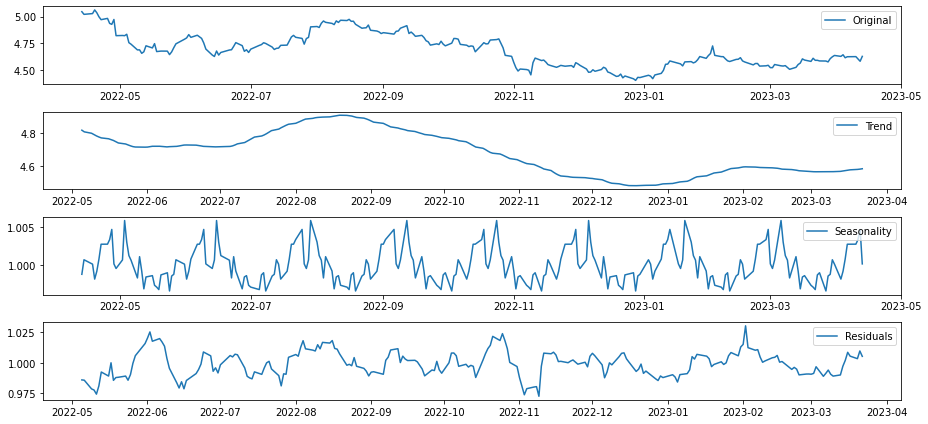

In [51]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [52]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.979701e+00
p-value                        1.851085e-07
#Lags Used                     3.000000e+00
Number of Observations Used    2.170000e+02
Critical Value (1%)           -3.460849e+00
Critical Value (5%)           -2.874953e+00
Critical Value (10%)          -2.573919e+00
dtype: float64


#### **4. 학습, 테스트 데이터셋 생성**

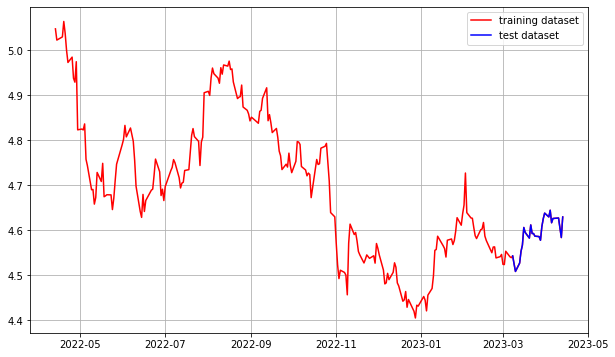

In [53]:
# 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### **5. 적정 ARIMA 모수 찾기**

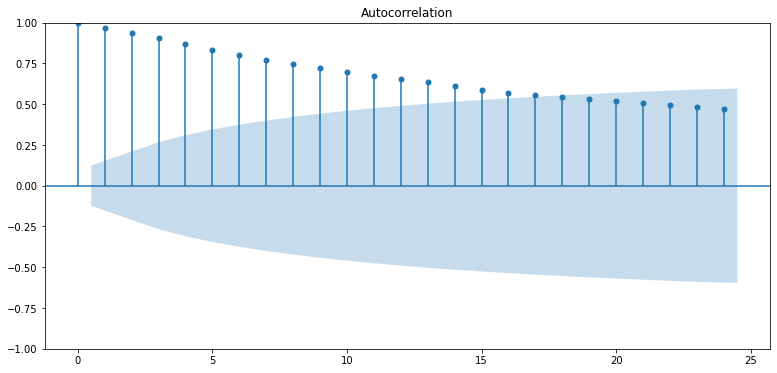

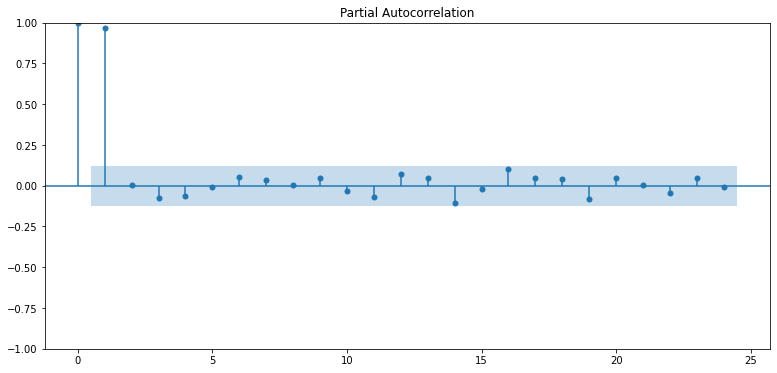

In [54]:
# ACF, PACF 그려보기
plot_acf(ts_log)  
plot_pacf(ts_log, method='ywm')
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.571173e+01
p-value                        1.356901e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


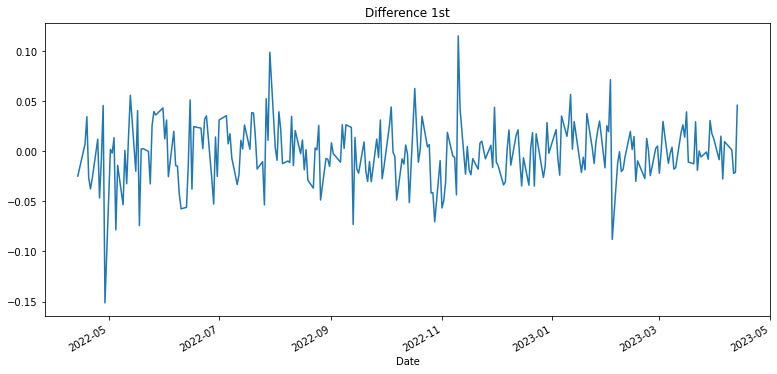

In [55]:
# 차분 안정성 확인
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#### **6. ARIMA 모델 훈련과 테스트**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 457.331
Date:                Fri, 14 Apr 2023   AIC                           -908.661
Time:                        05:27:32   BIC                           -898.426
Sample:                             0   HQIC                          -904.530
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6315      0.834      0.757      0.449      -1.003       2.266
ma.L1         -0.5963      0.866     -0.689      0.491      -2.293       1.101
sigma2         0.0010    6.7e-05     14.719      0.0

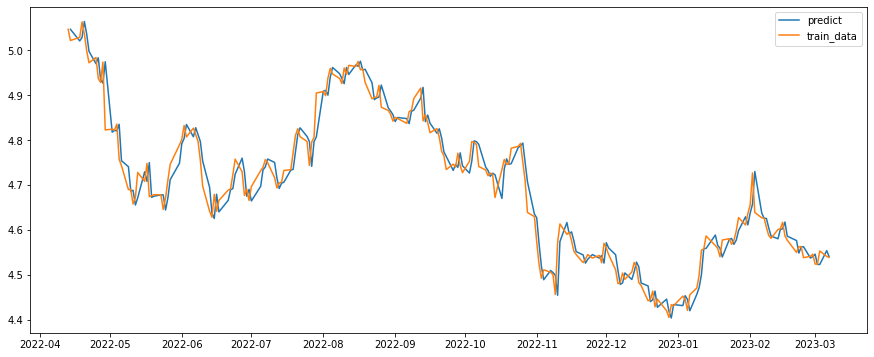

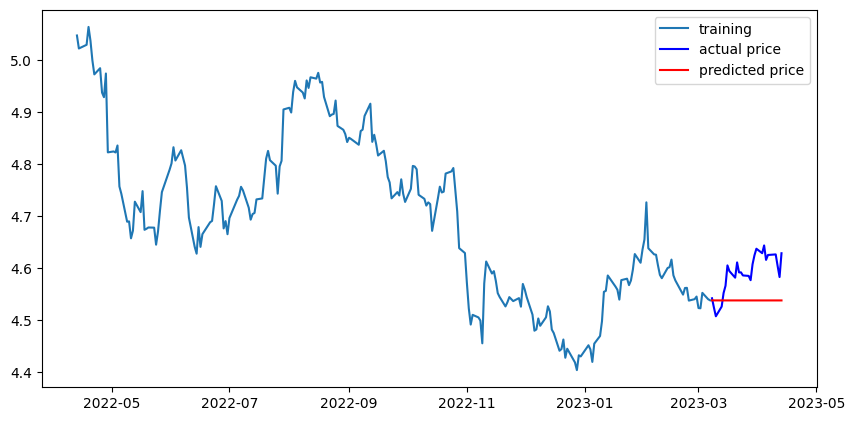

MSE:  38.83693759724343
MAE:  5.556128110877252
RMSE:  6.231928882556622
MAPE: 5.54%


In [56]:
arima_result(1,1,1)